In [70]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.formula.api import ols

from matplotlib import pyplot as plt

from sklearn import linear_model
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

import seaborn as sns

import pickle

In [71]:
nba_data = pd.read_csv('Finalized_nba_data_for_modeling.csv', index_col = 0)

In [72]:
nba_data['TS%'] = [x/10 for x in nba_data['TS%']]

# Creating Target and Feature Variables after EDA

In [73]:
target = nba_data['W']

In [74]:
features_list = []

In [75]:
for x in nba_data.columns:
    if (x == 'W') or (x == 'Tm') or (x == 'year') or (x == 'Pace'):
        pass
    else:
        features_list.append(x)

In [76]:
features = nba_data[features_list]

In [78]:
len(features_list)

17

# Running first model with simplified data (no interactions)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=23,test_size=0.2)  

# Creating a Scalar

In [80]:
scaler = StandardScaler()
final_scaler = scaler.fit(X_train)
X_train =pd.DataFrame(data=scaler.transform(X_train), columns=features_list)
X_test =pd.DataFrame(data=scaler.transform(X_test), columns=features_list)

# Standard Regression Model

In [81]:
#instantiate a linear regression object
lm = LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_train, y_train)

y_train_pred = lm.predict(X_train)

train_rmse = np.sqrt(metrics.mean_squared_error((y_train), y_train_pred))


print('Training Root Mean Squared Error:' , train_rmse)

y_pred = lm.predict(X_test)

test_rmse = np.sqrt(metrics.mean_squared_error((y_test), y_pred))

print('Testing Root Mean Squared Error:' , test_rmse)


print('Training: ', float(train_rmse), "vs. Testing: ", float(test_rmse))

Training Root Mean Squared Error: 4.0919493409603644
Testing Root Mean Squared Error: 5.151116850998439
Training:  4.0919493409603644 vs. Testing:  5.151116850998439


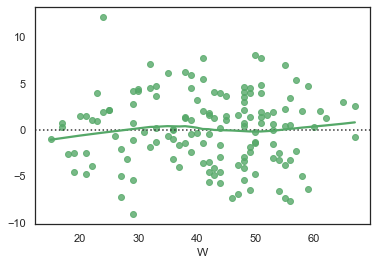

In [82]:
sns.residplot(y_train, y_train_pred,lowess=True, color="g")

# Recurvise Elimination Feature

In [83]:
from sklearn.feature_selection import RFECV

In [84]:
ols = linear_model.LinearRegression()

In [85]:
# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator=ols, step=1, cv=10, scoring='neg_mean_squared_error')

# Fit recursive feature eliminator 
selector.fit(X_train, y_train)

RFECV(cv=10,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
      step=1, verbose=0)

In [86]:
selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]

In [87]:
list(removed_rfe)

['3P%', '2P', 'FT%', 'DRB', '3PAr', 'FTr', 'TRB%', 'AST%', 'BLK%']

In [88]:
len(selected_rfe)

8

In [89]:
#instantiate a linear regression object
lm_rfe = LinearRegression()

#fit the linear regression to the data
lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

y_train_pred_rfe = lm_rfe.predict(X_train[selected_rfe])

train_rmse_rfe = np.sqrt(metrics.mean_squared_error((y_train), y_train_pred_rfe))


print('Training Root Mean Squared Error:' , train_rmse_rfe)

y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])

test_rmse_rfe = np.sqrt(metrics.mean_squared_error((y_test), y_pred_rfe))

print('Testing Root Mean Squared Error:' , test_rmse_rfe)


print("vs. Testing: ", float(test_rmse), 
      "vs. Testing rfe: ", float(test_rmse_rfe))

Training Root Mean Squared Error: 4.352046193081825
Testing Root Mean Squared Error: 5.676818305956155
vs. Testing:  5.151116850998439 vs. Testing rfe:  5.676818305956155


# KBest Selection

In [90]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

selector = SelectKBest(f_regression, k=10)

selector.fit(X_train, y_train)

SelectKBest(k=10, score_func=<function f_regression at 0x1a1f151560>)

In [91]:
selected_ftest = X_train.columns[selector.get_support()]
removed_ftest = X_train.columns[~selector.get_support()]

In [92]:
list(removed_ftest)

['ORB%', 'DRB%', '2P', 'FT%', 'FTr', 'TRB%', 'AST%']

In [93]:
len(selected_ftest)

10

In [94]:
#instantiate a linear regression object
lm_ftest = LinearRegression()

#fit the linear regression to the data
lm_ftest = lm_ftest.fit(X_train[selected_ftest], y_train)

y_train_pred_ftest = lm_ftest.predict((X_train[selected_ftest]))

train_rmse_ftest = np.sqrt(metrics.mean_squared_error((y_train), y_train_pred_ftest))


print('Training Root Mean Squared Error:' , train_rmse_ftest)

y_pred_ftest = lm_ftest.predict((X_test[selected_ftest]))

test_rmse_ftest = np.sqrt(metrics.mean_squared_error((y_test), y_pred_ftest))

print('Testing Root Mean Squared Error:' , test_rmse_ftest)


print("vs. Testing: ", float(test_rmse), 
      "vs. Testing rfe: ", float(test_rmse_rfe),
      "vs. Testing ftest: ", float(test_rmse_ftest))

Training Root Mean Squared Error: 5.183889426910179
Testing Root Mean Squared Error: 6.587124406298224
vs. Testing:  5.151116850998439 vs. Testing rfe:  5.676818305956155 vs. Testing ftest:  6.587124406298224


# Applying VIF 

In [95]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [96]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif.round(5)

,VIF Factor,features
0,1.70127,Age
1,1.50160,TOV%
2,2.51551,ORB%
3,1.86759,Dfg%
4,2.13008,DRB%
5,2.00758,3P%
6,5.49633,2P
7,1.81949,FT%
8,6.56101,DRB
9,6.45102,PTS


# Lasso Method

In [97]:
from sklearn.linear_model import Lasso

In [98]:
lasso = Lasso(alpha=0.01, max_iter = 5000, normalize=False)

final_lasso = lasso.fit(X_train,y_train)

y_train_pred_lasso = lasso.predict(X_train)
y_pred_lasso = lasso.predict(X_test)

train_rmse = metrics.mean_absolute_error(y_train, y_train_pred_lasso)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso))
print('Training Error: '+ str(train_rmse))
print('Testing Error: '+ str(test_rmse))

Training Error: 3.2369260317271142
Testing Error: 5.161862243226851


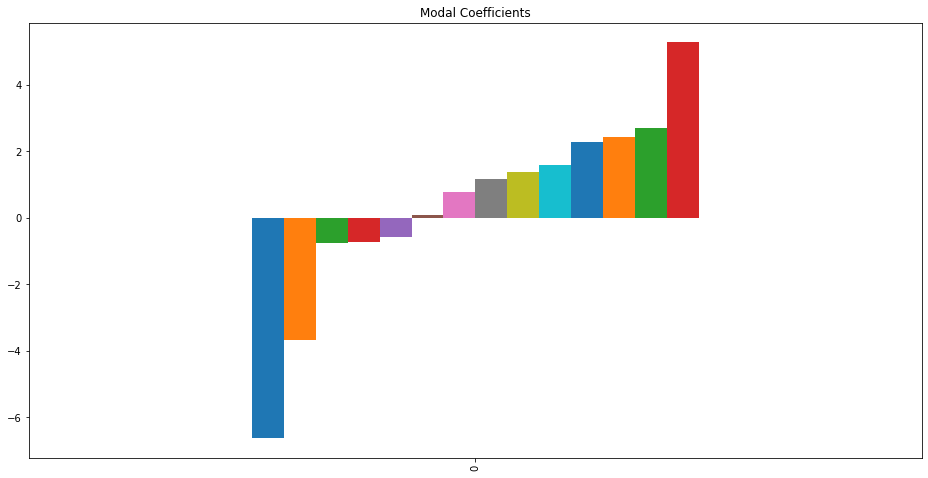

In [28]:
lasso_coef01 = pd.DataFrame(data=lasso.coef_).T
lasso_coef01.columns = X_train.columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
lasso_coef01.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8))

In [29]:
lasso_coef01.T

,0
Dfg%,-6.623592
TOV,-3.695383
FTr,-0.758077
FT%,-0.743552
BLK%,-0.568578
AST%,0.090475
3P%,0.767200
3PAr,1.158684
Age,1.383195
TRB%,1.572320


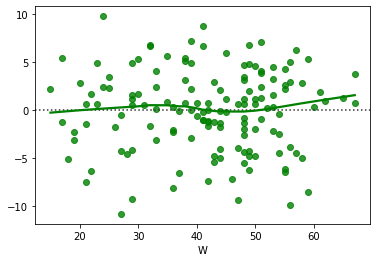

In [30]:
sns.residplot( y_train, y_train_pred_lasso,lowess=True, color="g")

# Statsmodels to get *R^2* value

In [31]:
X_endog = sm.add_constant(X_test)

In [32]:
res = sm.OLS(list(y_test), X_endog)

In [33]:
res.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     20.15
Date:                Thu, 07 May 2020   Prob (F-statistic):           4.54e-09
Time:                        09:22:34   Log-Likelihood:                -97.385
No. Observations:                  36   AIC:                             224.8
Df Residuals:                      21   BIC:                             248.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.1310      0.974     42.229      0.000      39.105      43.157
Age           -1.0839      1.670     -0.649      0.523      -4.557       2.389
ORB%           3.0919      1.386      2.231      0.037       0.210       5.974
Dfg%         -11.1310      1.560     -7.134      0.000     -14.376      -7.886
3P%           -0.4116      0.965     -0.426      0.674      -2.419       1.596
FT%           -1.3494      1.180     -1.143      0.266      -3.804       1.106
TOV           -7.1892      1.628     -4.417      0.000     -10.574      -3.804
PTS            4.8263      1.301      3.711      0.001       2.121       7.531
TS%            4.9864      1.501      3.323      0.003       1.866       8.107
3PAr           1.3405      1.395      0.961      0.348      -1.561       4.242
FTr           -0.6913      1.105     -0.626      0.538      -2.989       1.606
TRB%           0.7827      1.202      0.651      0.522      -1.718       3.283
AST%           1.9092      1.170      1.632      0.118      -0.524       4.342
STL%           2.6827      1.026      2.616      0.016       0.550       4.815
BLK%          -1.5246      1.028     -1.482      0.153      -3.663       0.614
==============================================================================
Omnibus:                        4.385   Durbin-Watson:                   2.179
Prob(Omnibus):                  0.112   Jarque-Bera (JB):                2.963
Skew:                          -0.600   Prob(JB):                        0.227
Kurtosis:                       3.732   Cond. No.                         6.70
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
'3PAr', 'FTr', 'BLK', 'STL'

('3PAr', 'FTr', 'BLK', 'STL')

The first model had everything included after removing from EDA analysis. After running multiple (different types of models i found that there were multiple features that could be removed, either because they had some collinearity (VIF) or because they did not have enough of an impact on the results (Lasso/Ftest/RFE)

# Test 2: 

# Removing additional features that did not do well in the first run

In [35]:
nba_data.columns

Index(['Age', 'W', 'ORB%', 'Dfg%', 'Tm', '3P%', 'FT%', 'TOV', 'PTS', 'TS%',
       '3PAr', 'FTr', 'TRB%', 'AST%', 'STL%', 'BLK%', 'year'],
      dtype='object')

In [36]:
nba_data_2 = nba_data.drop(columns = ['3PAr', 'FTr', 'FT%'])

# Creating Features and Target

In [37]:
target = nba_data_2['W']

In [38]:
features_list_2 = []

In [39]:
for x in nba_data_2.columns:
    if (x == 'W') or (x == 'Tm') or (x == 'year') or (x == 'Pace'):
        pass
    else:
        features_list_2.append(x)

In [40]:
features_2 = nba_data[features_list_2]

# Train test split test 2

In [41]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(features_2, target, random_state=23,test_size=0.2)  

# Scaling the Data 2

In [42]:
scaler = StandardScaler()
scaler.fit(X_train_2)
X_train_2 =pd.DataFrame(data=scaler.transform(X_train_2), columns=features_list_2)
X_test_2 =pd.DataFrame(data=scaler.transform(X_test_2), columns=features_list_2)

# Statsmodel Testing

In [43]:
X_endog_2 = sm.add_constant(X_test_2)

In [44]:
res_2 = sm.OLS(list(y_test_2), X_endog_2)

In [45]:
res_2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     25.69
Date:                Thu, 07 May 2020   Prob (F-statistic):           1.29e-10
Time:                        09:22:41   Log-Likelihood:                -99.577
No. Observations:                  36   AIC:                             223.2
Df Residuals:                      24   BIC:                             242.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.1531      0.920     44.727      0.000      39.254      43.052
Age           -0.4024      1.497     -0.269      0.790      -3.491       2.686
ORB%           2.1569      1.133      1.904      0.069      -0.181       4.495
Dfg%         -11.1237      1.494     -7.447      0.000     -14.207      -8.041
3P%           -0.2819      0.945     -0.298      0.768      -2.232       1.668
TOV           -6.1158      1.423     -4.299      0.000      -9.052      -3.179
PTS            4.4362      1.271      3.491      0.002       1.813       7.059
TS%            5.5797      1.211      4.606      0.000       3.079       8.080
TRB%           0.4117      1.094      0.376      0.710      -1.846       2.669
AST%           1.4532      1.045      1.390      0.177      -0.704       3.610
STL%           2.0159      0.886      2.275      0.032       0.187       3.844
BLK%          -1.3610      0.897     -1.517      0.142      -3.212       0.490
==============================================================================
Omnibus:                        0.004   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.998   Jarque-Bera (JB):                0.164
Skew:                           0.004   Prob(JB):                        0.921
Kurtosis:                       2.669   Cond. No.                         5.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# VIF Factor

In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [47]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_2.values, i) for i in range(X_train_2.shape[1])]
vif["features"] = X_train_2.columns
vif.round(5)

,VIF Factor,features
0,1.63534,Age
1,1.70490,ORB%
2,1.36488,Dfg%
3,1.61798,3P%
4,1.67862,TOV
5,1.84596,PTS
6,2.21320,TS%
7,1.57038,TRB%
8,1.34710,AST%
9,1.42414,STL%


# Lasso Method

In [48]:
from sklearn.linear_model import Lasso

In [49]:
lasso_2 = Lasso(alpha=0.01, max_iter = 5000, normalize=False)

lasso_2.fit(X_train_2,y_train_2)

y_train_pred_lasso_2 = lasso_2.predict(X_train_2)
y_pred_lasso_2 = lasso_2.predict(X_test_2)

train_rmse_2 = metrics.mean_absolute_error(y_train_2, y_train_pred_lasso_2)
test_rmse_2 = np.sqrt(metrics.mean_squared_error(y_test_2, y_pred_lasso_2))
print('Training Error: '+ str(train_rmse_2))
print('Testing Error: '+ str(test_rmse_2))

Training Error: 3.7935091438152195
Testing Error: 5.415136142446015


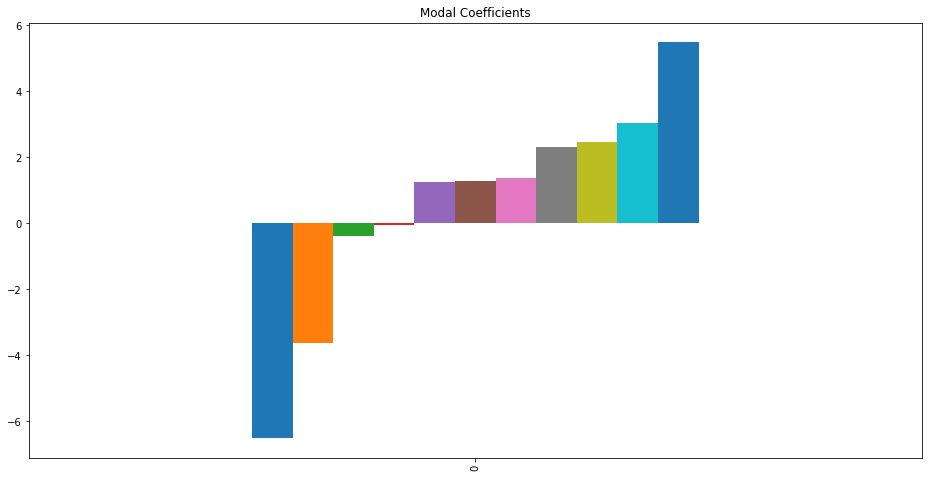

In [50]:
lasso_coef02 = pd.DataFrame(data=lasso_2.coef_).T
lasso_coef02.columns = X_train_2.columns
lasso_coef02 = lasso_coef02.T.sort_values(by=0).T
lasso_coef02.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8))

In [51]:
lasso_coef02.T

,0
Dfg%,-6.496142
TOV,-3.623073
BLK%,-0.374645
AST%,-0.061405
3P%,1.242247
Age,1.297250
TRB%,1.385943
ORB%,2.329456
STL%,2.456598
PTS,3.048622


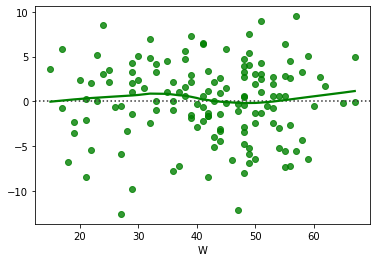

In [52]:
sns.residplot(y_train_2, y_train_pred_lasso_2,lowess=True, color="g")

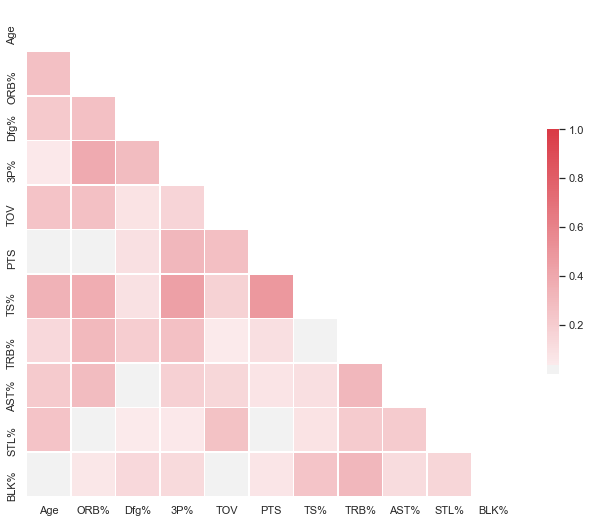

In [53]:
sns.set(style="white")


# Compute the correlation matrix
corr = np.abs(X_train_2.corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [54]:
# Create correlation matrix
corr_matrix = X_train_2.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,Age,ORB%,Dfg%,3P%,TOV,PTS,TS%,TRB%,AST%,STL%,BLK%
Age,NaN,0.271364,0.220461,0.053916,0.254811,0.000604,0.347336,0.137644,0.211632,0.251010,0.009606
ORB%,NaN,NaN,0.267864,0.385869,0.266518,0.021138,0.372124,0.309542,0.293840,0.005958,0.057916
Dfg%,NaN,NaN,NaN,0.294204,0.086411,0.098712,0.094116,0.201259,0.036762,0.041797,0.140013
3P%,NaN,NaN,NaN,NaN,0.160948,0.320172,0.441005,0.273558,0.186827,0.052032,0.125608
TOV,NaN,NaN,NaN,NaN,NaN,0.279120,0.175093,0.042942,0.147468,0.259844,0.008999
PTS,NaN,NaN,NaN,NaN,NaN,NaN,0.487256,0.103822,0.076054,0.019040,0.070252
TS%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.014641,0.104371,0.081845,0.247779
TRB%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.315760,0.203882,0.318281
AST%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.204649,0.124974
STL%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.156627


# Checking Recursive method to see what values it may still remove

In [55]:
from sklearn.feature_selection import RFECV

In [56]:
ols = linear_model.LinearRegression()

In [57]:
# Create recursive feature eliminator that scores features by mean squared errors
selector = RFECV(estimator=ols, step=1, cv=10, scoring='neg_mean_squared_error')

# Fit recursive feature eliminator 
selector.fit(X_train_2, y_train_2)

RFECV(cv=10,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
      step=1, verbose=0)

In [58]:
selected_rfe_2 = X_train_2.columns[selector.support_]
removed_rfe_2 = X_train_2.columns[~selector.support_]

In [59]:
list(removed_rfe_2)

['AST%', 'BLK%']

In [60]:
#instantiate a linear regression object
lm_rfe = LinearRegression()

#fit the linear regression to the data
lm_rfe.fit(X_train_2[selected_rfe], y_train_2)

y_train_pred_rfe_2 = lm_rfe.predict(X_train_2[selected_rfe])

train_rmse_rfe_2 = np.sqrt(metrics.mean_squared_error((y_train_2), y_train_pred_rfe_2))


print('Training Root Mean Squared Error:' , train_rmse_rfe_2)

y_pred_rfe_2 = lm_rfe.predict(X_test_2[selected_rfe])

test_rmse_rfe_2 = np.sqrt(metrics.mean_squared_error((y_test_2), y_pred_rfe_2))

print('Testing Root Mean Squared Error:' , test_rmse_rfe_2)


print("vs. Testing: ", float(test_rmse_2), 
      "vs. Testing rfe: ", float(test_rmse_rfe_2))

KeyError: "['3PAr', 'FTr', 'FT%'] not in index"

In [61]:
sns.residplot(y_train_2, y_train_pred_rfe_2,lowess=True, color="g")

NameError: name 'y_train_pred_rfe_2' is not defined

# Test 3 - 

# Taking all the original data from the first test and trying to create some interactions

In [103]:
nba_data_3 = nba_data

In [104]:
nba_data_3['TS_Ast'] = [nba_data_3['TS%'][i]*nba_data_3['AST%'][i] for i in range(len(nba_data_3['TS%']))]

In [105]:
nba_data_3['TS_ORB'] = [nba_data_3['TS%'][i]*nba_data_3['ORB%'][i] for i in range(len(nba_data_3['TS%']))]

In [106]:
nba_data_3['TS_Pts'] = [nba_data_3['TS%'][i]*nba_data_3['PTS'][i] for i in range(len(nba_data_3['TS%']))]

In [107]:
nba_data_3['TS%'] = [x/10 for x in nba_data_3['TS%']]

# Target and features for 3rd test

In [108]:
target = nba_data_3['W']

In [109]:
features_list_3 = []

In [110]:
for x in nba_data_3.columns:
    if (x == 'W') or (x == 'Tm') or (x == 'year') or (x == 'Pace'):
        pass
    else:
        features_list_3.append(x)

In [111]:
features_3 = nba_data_3[features_list_3]

In [112]:
X_train_3, X_test_3, y_train_3, y_test_3= train_test_split(features_3, target, random_state=23,test_size=0.2)  

In [113]:
scaler = StandardScaler()
final_scaler = scaler.fit(X_train_3)
X_train_3 =pd.DataFrame(data=scaler.transform(X_train_3), columns=features_list_3)
X_test_3 =pd.DataFrame(data=scaler.transform(X_test_3), columns=features_list_3)

# Recursive method 3

In [114]:
from sklearn.feature_selection import RFECV

In [115]:
ols = linear_model.LinearRegression()

In [116]:
# Create recursive feature eliminator that scores features by mean squared errors
selector_3 = RFECV(estimator=ols, step=1, cv=10, scoring='neg_mean_squared_error')

# Fit recursive feature eliminator 
selector_3.fit(X_train_3, y_train_3)

RFECV(cv=10,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
      step=1, verbose=0)

In [117]:
selected_rfe_3 = X_train_3.columns[selector_3.support_]
removed_rfe_3 = X_train_3.columns[~selector_3.support_]

In [118]:
list(removed_rfe_3)

['2P', 'FT%', 'DRB', 'PTS', 'TS%', '3PAr', 'FTr', 'TRB%', 'BLK%']

In [78]:
#instantiate a linear regression object
lm_rfe = LinearRegression()

#fit the linear regression to the data
lm_rfe.fit(X_train_3[selected_rfe], y_train_3)

y_train_pred_rfe_3 = lm_rfe.predict(X_train_3[selected_rfe])

train_rmse_rfe_3 = np.sqrt(metrics.mean_squared_error((y_train_3), y_train_pred_rfe_3))


print('Training Root Mean Squared Error:' , train_rmse_rfe_3)

y_pred_rfe_3 = lm_rfe.predict(X_test_3[selected_rfe])

test_rmse_rfe_3 = np.sqrt(metrics.mean_squared_error((y_test_3), y_pred_rfe_3))

print('Testing Root Mean Squared Error:' , test_rmse_rfe_3)


print("vs. Testing: ", float(test_rmse_2), 
      "vs. Testing rfe: ", float(test_rmse_rfe_3))

Training Root Mean Squared Error: 7.214710999838886
Testing Root Mean Squared Error: 9.273919835681488
vs. Testing:  9.508223863268663 vs. Testing rfe:  9.273919835681488


# VIF Test 3

In [142]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_3.values, i) for i in range(X_train_3.shape[1])]
vif["features"] = X_train_3.columns
vif.round(5)

,VIF Factor,features
0,1.53796,Age
1,1282.75952,ORB%
2,1.88482,3P%
3,1.70425,FT%
4,1.81487,TOV
5,1.97102,PTS
6,316.22918,TS%
7,2.45396,3PAr
8,1.32591,FTr
9,1.82445,TRB%


This VIF showed that the features that came from the interactions had a very high collinearity to the interactions

In [80]:
X_endog_3 = sm.add_constant(X_test_3)
res_3 = sm.OLS(list(y_test_3), X_endog_3)
res_3.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     4.436
Date:                Wed, 06 May 2020   Prob (F-statistic):            0.00120
Time:                        20:04:48   Log-Likelihood:                -119.07
No. Observations:                  36   AIC:                             270.1
Df Residuals:                      20   BIC:                             295.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.5995      1.827     22.227      0.000      36.789      44.410
Age            6.2953      3.074      2.048      0.054      -0.117      12.708
ORB%         -46.0690     67.916     -0.678      0.505    -187.739      95.601
3P%            2.4294      1.642      1.480      0.155      -0.995       5.854
FT%           -2.4603      2.383     -1.032      0.314      -7.432       2.511
TOV           -3.3825      3.076     -1.100      0.284      -9.798       3.033
PTS           -1.2705      1.829     -0.695      0.495      -5.086       2.545
TS%          -14.7847     41.287     -0.358      0.724    -100.907      71.338
3PAr          -0.8293      3.081     -0.269      0.791      -7.257       5.598
FTr            0.3409      2.454      0.139      0.891      -4.777       5.459
TRB%           1.3793      2.411      0.572      0.574      -3.650       6.409
AST%          -6.8406     79.169     -0.086      0.932    -171.984     158.303
STL%           1.0483      1.904      0.551      0.588      -2.924       5.020
BLK%           0.5453      1.967      0.277      0.784      -3.557       4.648
TS_Ast        10.7901     87.607      0.123      0.903    -171.956     193.536
TS_ORB        45.9149     62.949      0.729      0.474     -85.394     177.224
==============================================================================
Omnibus:                        0.356   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.837   Jarque-Bera (JB):                0.476
Skew:                          -0.204   Prob(JB):                        0.788
Kurtosis:                       2.612   Cond. No.                         182.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Model 3 was to test with all of the new features added on taking into account true shooting for assists, orb and pts. This gave the values more correlation but new model is necessary to remove excess features that are now too collinear.

# Test 4 

# Looking for relations after removing variables that correlate too strongly to eachother and the variables that have a weak affect on the data

In [119]:
nba_data_4 = nba_data.drop(columns = ['ORB%', '3PAr', 'FTr', 'AST%', '3P%', 
                                      'STL%', 'BLK%', 'PTS'])

In [120]:
features_list_4 = []

In [121]:
for x in nba_data_4:
    if (x == 'W') or (x == 'Tm') or (x == 'year') or (x == 'Pace'):
        pass
    else:
        features_list_4.append(x)

In [122]:
features_4 = nba_data_4[features_list_4]

Train test split

In [123]:
X_train_4, X_test_4, y_train_4, y_test_4= train_test_split(features_4, target, random_state=23,test_size=0.2)  

Scaler

In [124]:
scaler = StandardScaler()
final_scaler = scaler.fit(X_train_4)
X_train_4 =pd.DataFrame(data=scaler.transform(X_train_4), columns=features_list_4)
X_test_4 =pd.DataFrame(data=scaler.transform(X_test_4), columns=features_list_4)

Quick look at the data

In [125]:
X_endog_4 = sm.add_constant(X_test_4)
res_4 = sm.OLS(list(y_test_4), X_endog_4)
res_4.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     16.43
Date:                Thu, 07 May 2020   Prob (F-statistic):           1.64e-08
Time:                        10:42:51   Log-Likelihood:                -104.77
No. Observations:                  36   AIC:                             235.5
Df Residuals:                      23   BIC:                             256.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.6507      1.126     37.004      0.000      39.322      43.979
Age            1.5302      1.579      0.969      0.343      -1.737       4.797
TOV%          -3.5172      1.600     -2.198      0.038      -6.828      -0.207
Dfg%         -12.7257      2.049     -6.212      0.000     -16.964      -8.488
DRB%           2.1364      1.603      1.333      0.196      -1.179       5.452
2P            -1.2773      1.223     -1.044      0.307      -3.808       1.253
FT%           -1.0307      1.478     -0.697      0.493      -4.088       2.027
DRB           -4.1323      2.335     -1.770      0.090      -8.963       0.699
TS%           -0.0085      3.044     -0.003      0.998      -6.304       6.288
TRB%           0.2572      1.612      0.160      0.875      -3.077       3.592
TS_Ast         0.4579      1.376      0.333      0.742      -2.389       3.305
TS_ORB         1.9663      1.350      1.457      0.159      -0.826       4.758
TS_Pts         7.8367      3.556      2.204      0.038       0.481      15.192
==============================================================================
Omnibus:                        1.385   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.500   Jarque-Bera (JB):                0.754
Skew:                          -0.347   Prob(JB):                        0.686
Kurtosis:                       3.146   Cond. No.                         10.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

RFE Check to see if there are any features it would remove

In [126]:
# Create recursive feature eliminator that scores features by mean squared errors
selector_4 = RFECV(estimator=ols, step=1, cv=10, scoring='neg_mean_squared_error')

# Fit recursive feature eliminator 
selector_4.fit(X_train_4, y_train_4)

RFECV(cv=10,
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='neg_mean_squared_error',
      step=1, verbose=0)

In [127]:
selected_rfe_4 = X_train_4.columns[selector_4.support_]
removed_rfe_4 = X_train_4.columns[~selector_4.support_]

Lasso test to check the value

In [128]:
lasso_4 = Lasso(alpha=0.01, max_iter = 5000, normalize=False)

lasso_4.fit(X_train_4,y_train_4)

y_train_pred_lasso_4 = lasso_4.predict(X_train_4)
y_pred_lasso_4 = lasso_4.predict(X_test_4)

train_rmse_4 = metrics.mean_absolute_error(y_train_4, y_train_pred_lasso_4)
test_rmse_4 = np.sqrt(metrics.mean_squared_error(y_test_4, y_pred_lasso_4))
print('Training Error: '+ str(train_rmse_4))
print('Testing Error: '+ str(test_rmse_4))

Training Error: 3.895388273981841
Testing Error: 6.170272990269359


Ran this model to check how the new features would run with the older features it came from being removed. Only kept true shooting % as it is one of the most valuable features to the final data